In [1]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
bids_folder = '/data/ds-risk'
model_label = 'probit_neural6'
session = '7t2'

In [3]:
df = get_data(model_label, '7t2', bids_folder)
model = build_model(model_label, df, session, bids_folder)

100%|██████████| 30/30 [00:01<00:00, 25.34it/s]


In [9]:
idata = az.from_netcdf('/data/ds-risk/derivatives/cogmodels/model-probit_neural6_ses-7t2_trace.netcdf')

In [10]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)

['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


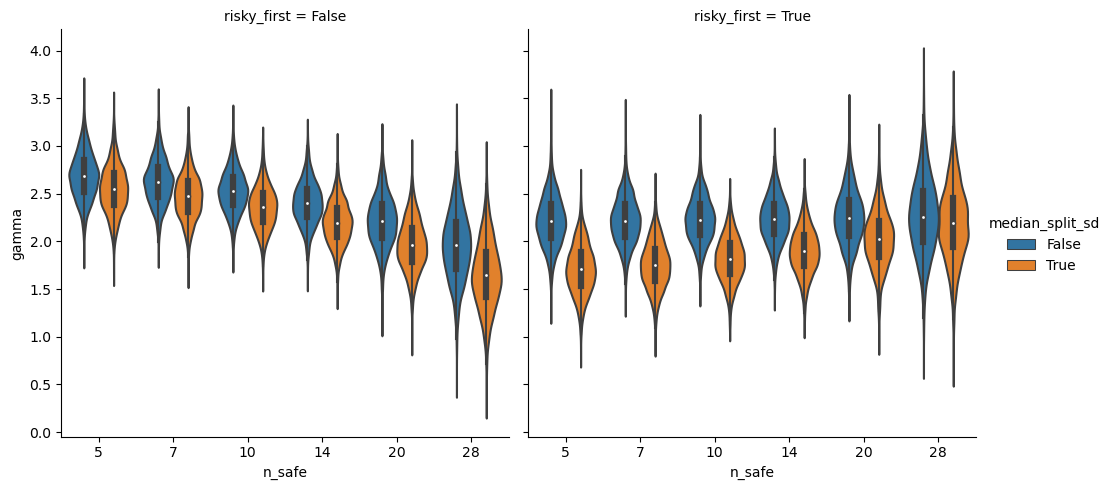

In [11]:
tmp = gamma.stack([-2, -1]).reset_index() 
tmp['n_safe'] = pd.Categorical(tmp['n_safe'].astype(int))
sns.catplot(tmp, x='n_safe', col='risky_first', hue='median_split_sd', kind='violin', y='gamma')

In [12]:
rnp = np.exp(intercept['intercept']/gamma['gamma'])

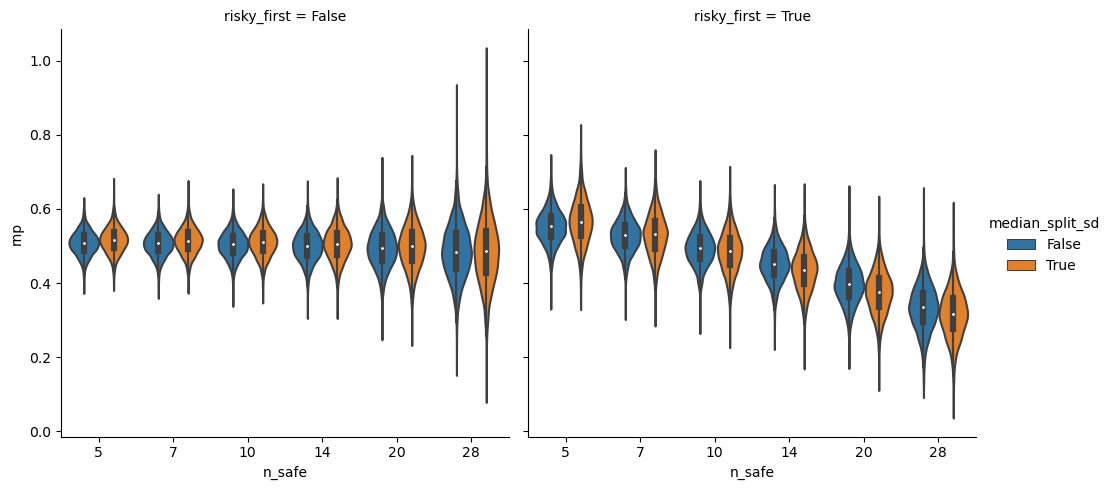

In [13]:
tmp = rnp.stack([-2, -1]).to_frame('rnp').reset_index()
tmp['n_safe'] = pd.Categorical(tmp['n_safe'].astype(int))
sns.catplot(tmp, x='n_safe', col='risky_first', hue='median_split_sd', kind='violin', y='rnp')

In [14]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)

mean_intercept, mean_gamma = intercept.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('intercept'), gamma.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('gamma')
mean_rnp = np.clip(np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp'), 0, 1)

['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


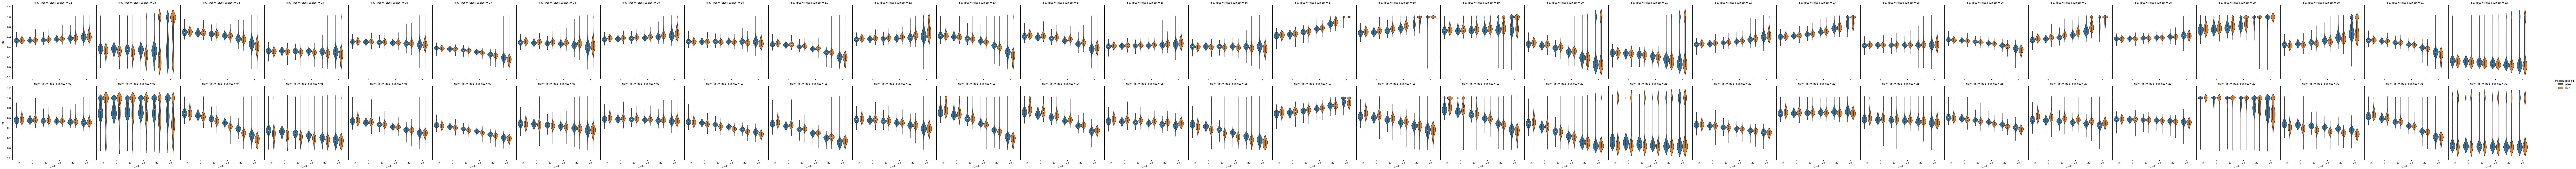

In [15]:
tmp = rnp.stack([-2, -1]).to_frame('rnp').reset_index()
tmp['n_safe'] = pd.Categorical(tmp['n_safe'].astype(int))
sns.catplot(tmp, x='n_safe', row='risky_first', hue='median_split_sd', kind='violin', y='rnp', col='subject')

In [16]:
import matplotlib.pyplot as plt

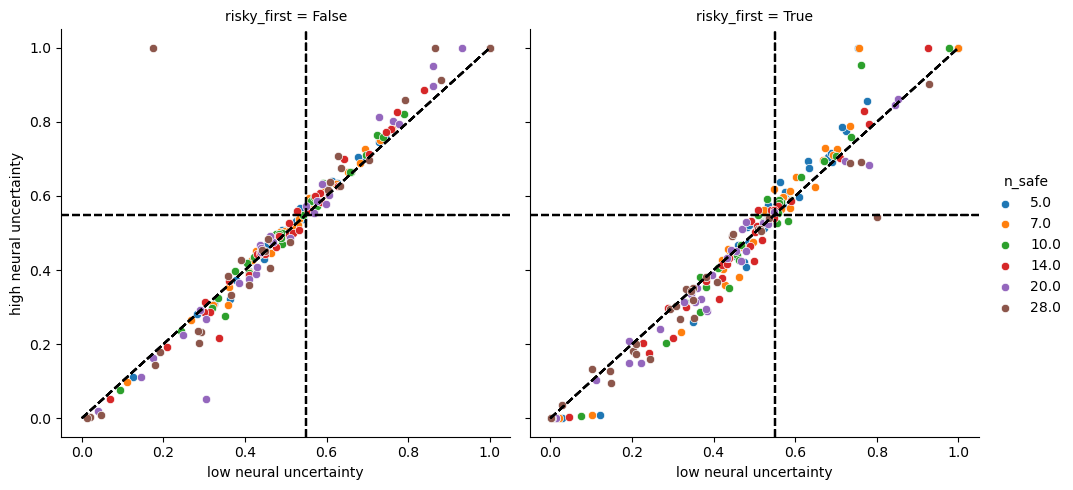

In [17]:
tmp = mean_rnp.unstack('median_split_sd')['rnp']
tmp.columns = ['low neural uncertainty', 'high neural uncertainty']

fac = sns.FacetGrid(tmp.reset_index(), col='risky_first', hue='n_safe', height=5.)
fac.map(sns.scatterplot, 'low neural uncertainty', 'high neural uncertainty')

fac.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 1], c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axvline(0.55, c='k', ls='--'))

fac.add_legend()

In [18]:
mean_mean_rnp = mean_rnp.groupby(['subject', 'risky_first']).mean()

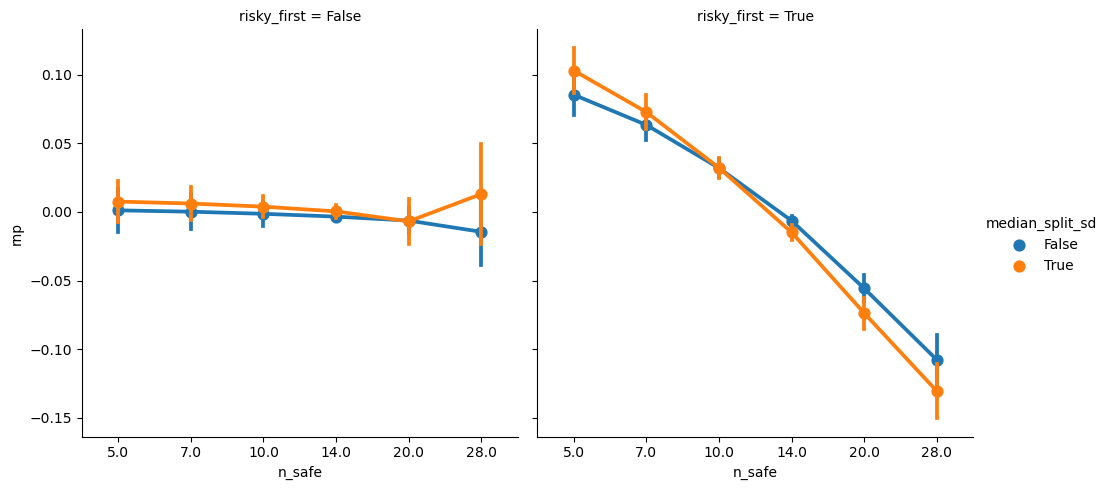

In [19]:
tmp = (mean_rnp - mean_mean_rnp)


sns.catplot(tmp.reset_index(), x='n_safe', y='rnp', hue='median_split_sd', kind='point', col='risky_first', errorbar='se')

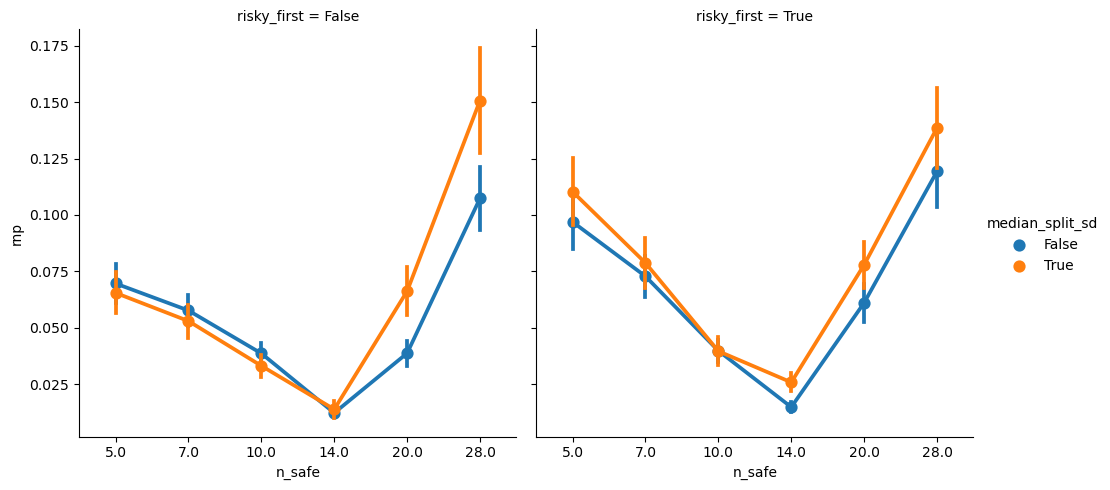

In [20]:
tmp = (mean_rnp - mean_mean_rnp).abs()


sns.catplot(tmp.reset_index(), x='n_safe', y='rnp', hue='median_split_sd', kind='point', col='risky_first', errorbar='se')

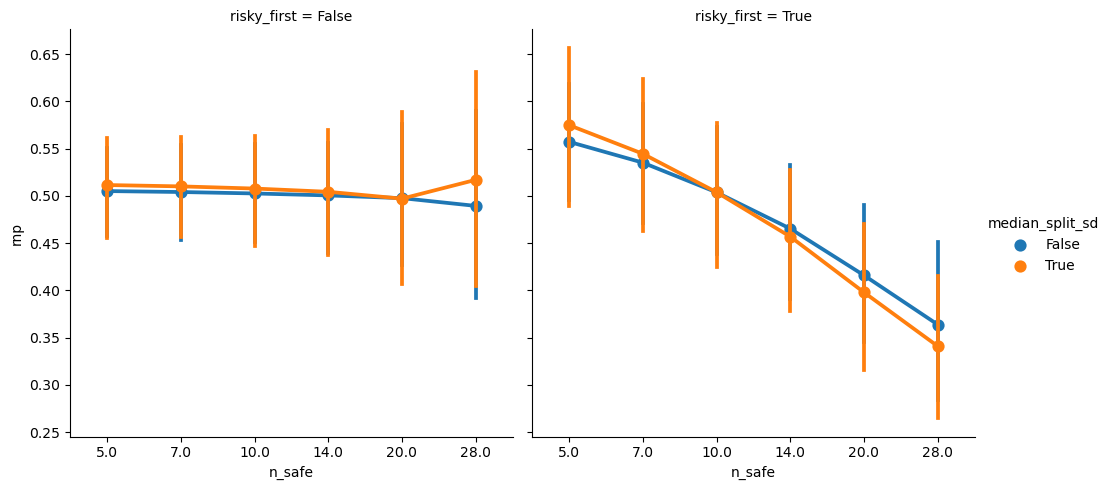

In [21]:
sns.catplot(mean_rnp.reset_index(), x='n_safe', y='rnp', hue='median_split_sd', col='risky_first', kind='point')

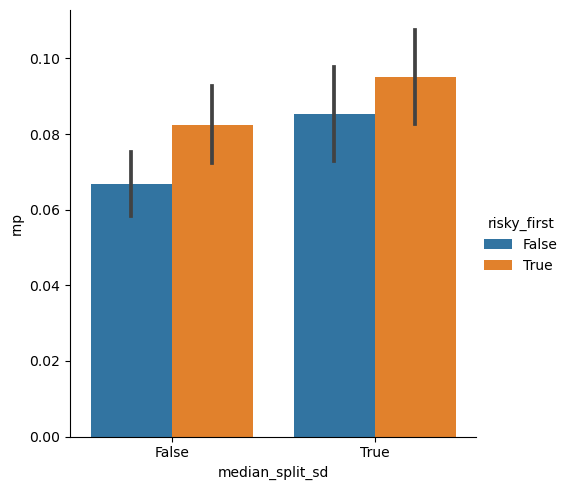

In [22]:
tmp = mean_rnp.groupby(['subject', 'median_split_sd', 'risky_first']).std()

sns.catplot(tmp.reset_index(), x='median_split_sd', hue='risky_first', y='rnp', kind='bar', errorbar='se')

In [23]:
import pingouin

In [24]:
pingouin.rm_anova(data=tmp.reset_index(), dv='rnp', within=['risky_first', 'median_split_sd'], subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/distribution.py:481: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby(level=1, axis=1, observed=True).diff(axis=1).dropna(axis=1)


Source        SS  ddof1  ddof2        MS         F  \
0                    risky_first  0.004815      1     29  0.004815  1.271273   
1                median_split_sd  0.007240      1     29  0.007240  4.737219   
2  risky_first * median_split_sd  0.000270      1     29  0.000270  1.860034   

      p-unc  p-GG-corr       ng2  eps  
0  0.268771   0.268771  0.011248  1.0  
1  0.037804   0.037804  0.016820  1.0  
2  0.183114   0.183114  0.000638  1.0

# Model 7

In [1]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bids_folder = '/data/ds-risk'

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
model_label = 'probit_neural7'
session = '3t2'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-probit_neural7_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 24.13it/s]


['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


risky_first
False    0.04675
True     0.04675
dtype: float64

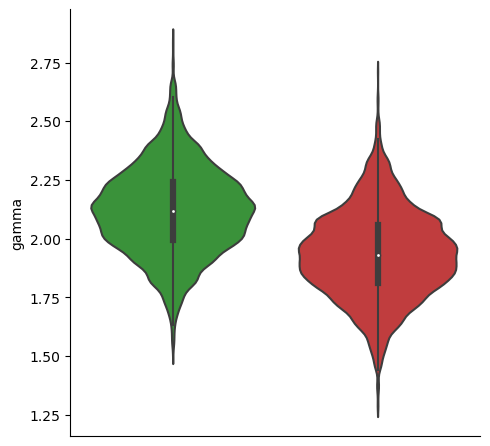

In [3]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='gamma', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

risky_first
False    0.11325
True     0.11325
dtype: float64

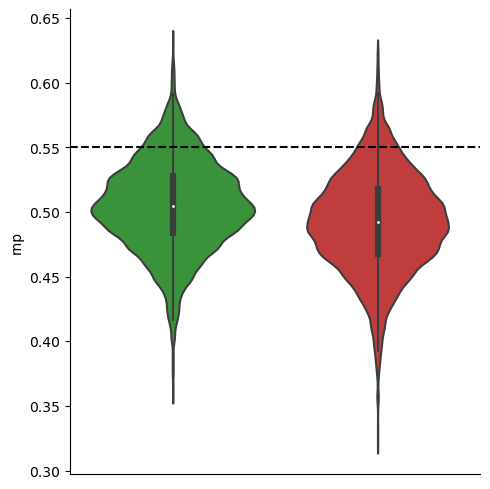

In [4]:
tmp = rnp.stack([0,1]).to_frame('rnp')

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='rnp', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('rnp', True)] - d[('rnp', False)]) > 0.0).mean())

In [5]:
sns.set_context('talk')

['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


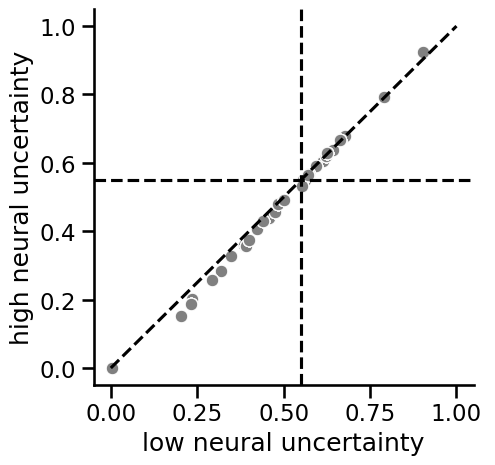

In [6]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)

mean_intercept, mean_gamma = intercept.groupby(['subject', 'n_safe',  'median_split_sd']).mean().mean(1).to_frame('intercept'), gamma.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('gamma')
mean_rnp = np.clip(np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp'), 0, 1)

tmp = mean_rnp.unstack('median_split_sd')['rnp']
tmp.columns = ['low neural uncertainty', 'high neural uncertainty']

fac = sns.FacetGrid(tmp.reset_index(), height=5., palette=['gray'])
fac.map(sns.scatterplot, 'low neural uncertainty', 'high neural uncertainty', color='gray')

fac.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 1], c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axvline(0.55, c='k', ls='--'))

fac.add_legend()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_32147/592854228.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color='gray')


Text(0.5, 1.0, 'High neural uncertainty ~ Low neural uncertainty')

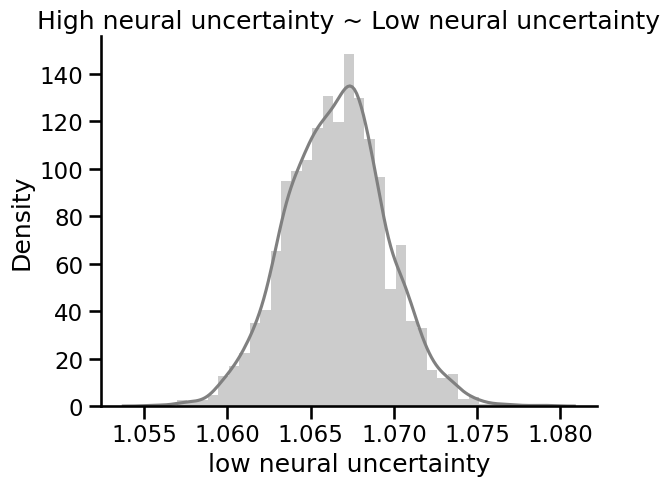

In [7]:
import bambi 

model = bambi.Model('"high neural uncertainty" ~ "low neural uncertainty"', data=tmp.reset_index())

idata_lm = model.fit(cores=1) # cores=1, otherwise fortran error

sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color='gray')
sns.despine()
plt.title('High neural uncertainty ~ Low neural uncertainty')

In [9]:
model_label = 'probit_neural7'
session = '7t2'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-probit_neural7_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 24.24it/s]


['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


risky_first
False    0.0165
True     0.0165
dtype: float64

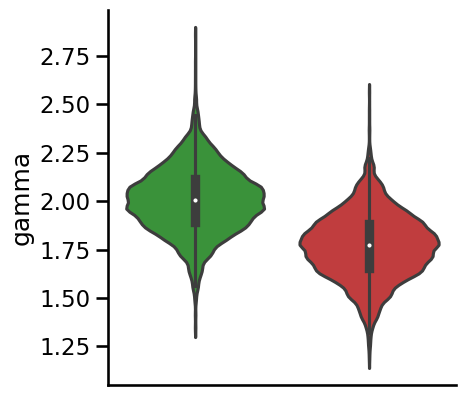

In [10]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='gamma', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

risky_first
False    0.3795
True     0.3795
dtype: float64

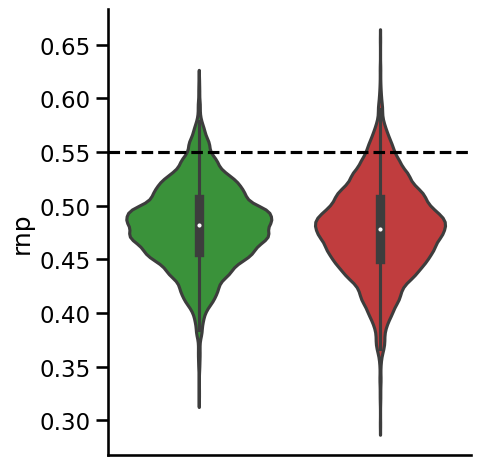

In [11]:
tmp = rnp.stack([0,1]).to_frame('rnp')

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='rnp', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('rnp', True)] - d[('rnp', False)]) > 0.0).mean())

['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


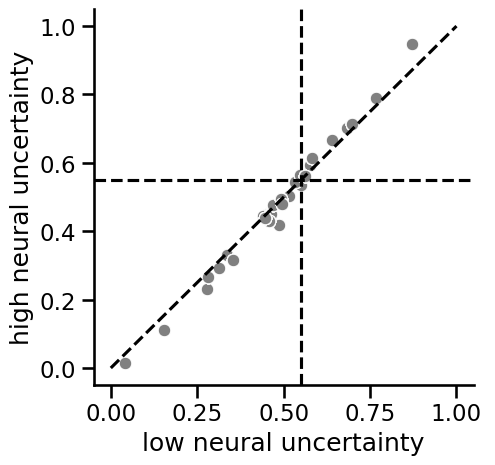

In [12]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)

mean_intercept, mean_gamma = intercept.groupby(['subject', 'n_safe',  'median_split_sd']).mean().mean(1).to_frame('intercept'), gamma.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('gamma')
mean_rnp = np.clip(np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp'), 0, 1)

tmp = mean_rnp.unstack('median_split_sd')['rnp']
tmp.columns = ['low neural uncertainty', 'high neural uncertainty']

fac = sns.FacetGrid(tmp.reset_index(), height=5., palette=['gray'])
fac.map(sns.scatterplot, 'low neural uncertainty', 'high neural uncertainty', color='gray')

fac.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 1], c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axvline(0.55, c='k', ls='--'))

fac.add_legend()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_32147/592854228.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color='gray')


Text(0.5, 1.0, 'High neural uncertainty ~ Low neural uncertainty')

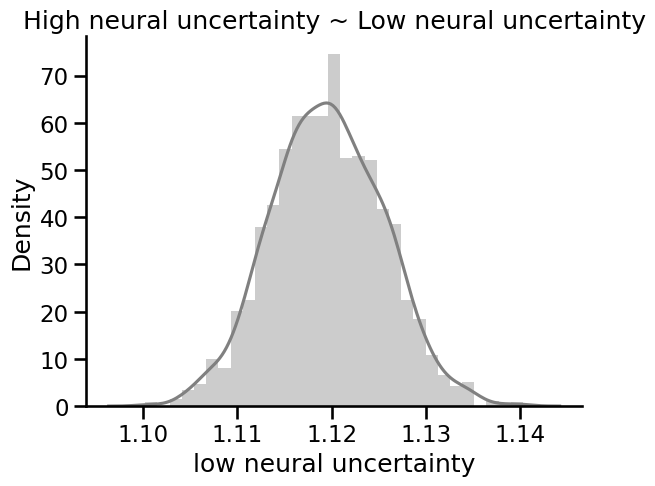

In [13]:
import bambi 

model = bambi.Model('"high neural uncertainty" ~ "low neural uncertainty"', data=tmp.reset_index())

idata_lm = model.fit(cores=1) # cores=1, otherwise fortran error

sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color='gray')
sns.despine()
plt.title('High neural uncertainty ~ Low neural uncertainty')

# Model 8


In [19]:
import pingouin
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
model_label = 'probit_neural8'
session = '3t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 25.88it/s]


In [21]:
sns.set_context('talk')

['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


risky_first
False    0.20800
True     0.06275
dtype: float64

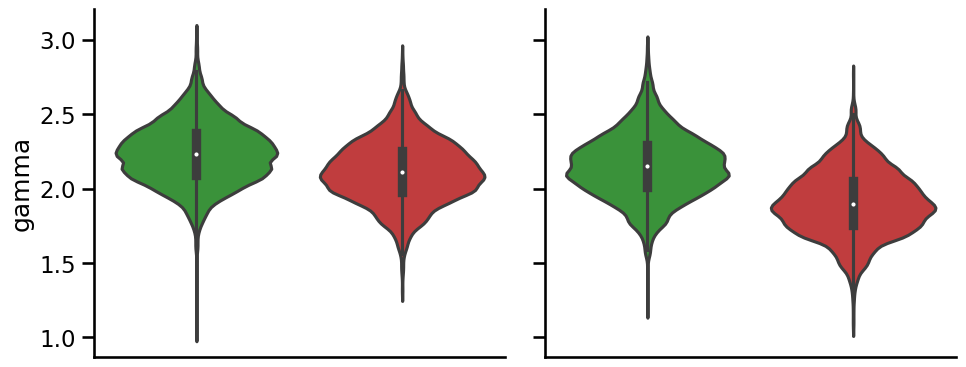

In [22]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='gamma', col='Order', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

risky_first
False    0.38825
True     0.06875
dtype: float64

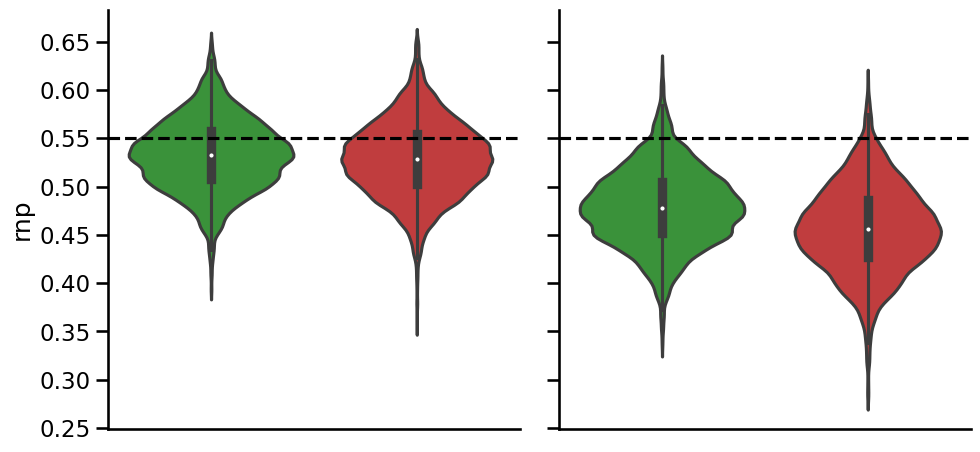

In [23]:
tmp = rnp.stack([0,1]).to_frame('rnp')

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='rnp', col='risky_first', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('rnp', True)] - d[('rnp', False)]) > 0.0).mean())

['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


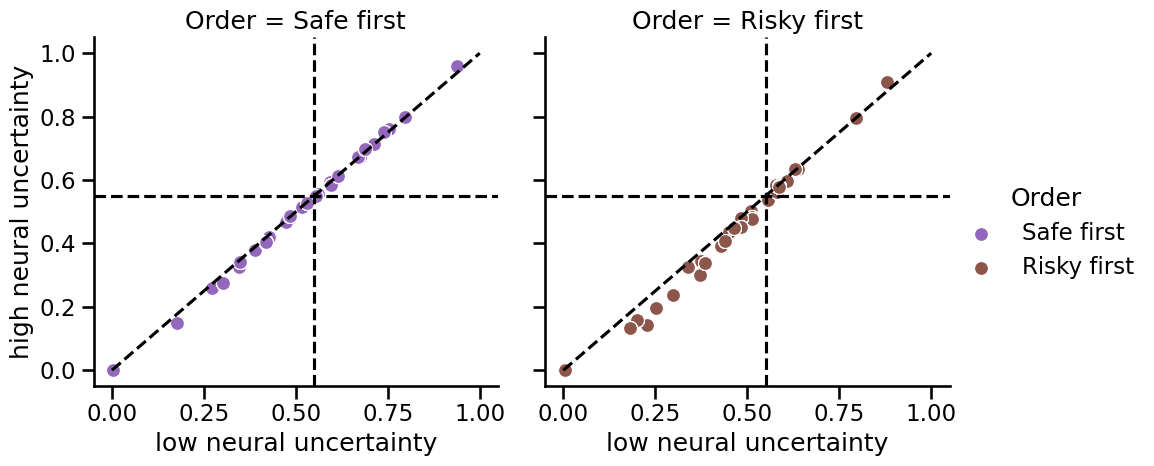

In [24]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)

mean_intercept, mean_gamma = intercept.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('intercept'), gamma.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('gamma')
mean_rnp = np.clip(np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp'), 0, 1)

tmp = mean_rnp.unstack('median_split_sd')['rnp']
tmp.columns = ['low neural uncertainty', 'high neural uncertainty']
tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.FacetGrid(tmp.reset_index(), col='Order', height=5., hue='Order', palette=sns.color_palette()[4:])
fac.map(sns.scatterplot, 'low neural uncertainty', 'high neural uncertainty', s=100)

fac.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 1], c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axvline(0.55, c='k', ls='--'))

fac.add_legend()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_28332/1704015999.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color=sns.color_palette()[5])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_28332/1704015999.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histog

Text(0.5, 1.0, 'High neural uncertainty ~ Low neural uncertainty')

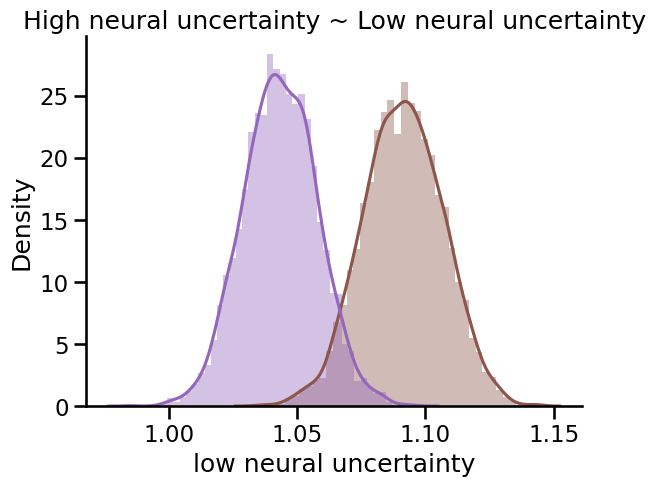

In [25]:
import bambi 

model = bambi.Model('"high neural uncertainty" ~ "low neural uncertainty"*Order + (1|subject)', data=tmp.groupby(['subject', 'Order']).mean().reset_index())

idata_lm = model.fit()

sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color=sns.color_palette()[5])
sns.distplot(idata_lm.posterior['low neural uncertainty'] + idata_lm.posterior['low neural uncertainty:Order'], label='Risky first',
             color=sns.color_palette()[4])
sns.despine()
plt.title('High neural uncertainty ~ Low neural uncertainty')

In [11]:
model_label = 'probit_neural8'
session = '7t2'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 26.16it/s]


['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


risky_first
False    0.1195
True     0.0370
dtype: float64

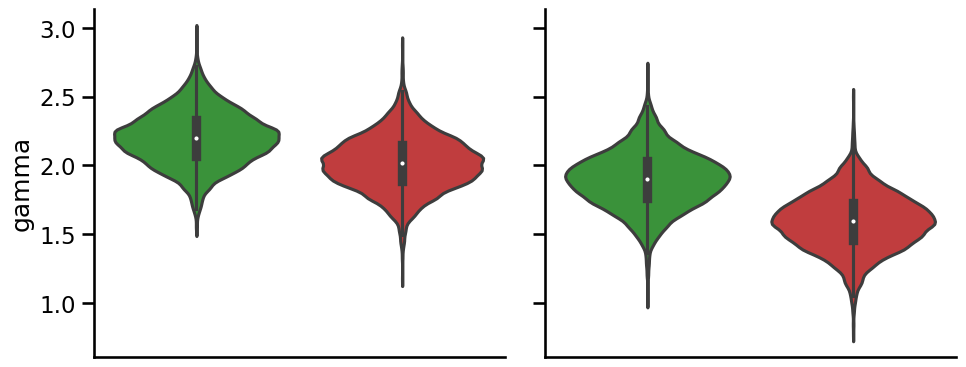

In [12]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='gamma', col='Order', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

risky_first
False    0.64125
True     0.20250
dtype: float64

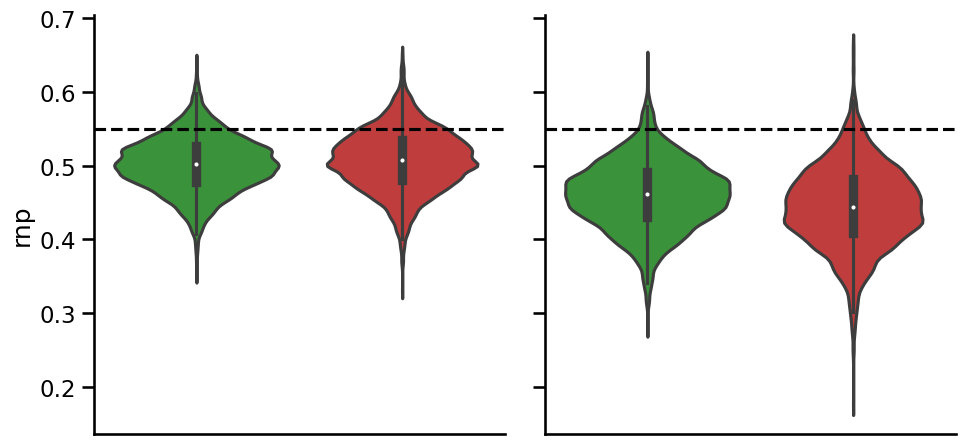

In [13]:
tmp = rnp.stack([0,1]).to_frame('rnp')

fac = sns.catplot(tmp.reset_index(), x='median_split_sd', y='rnp', col='risky_first', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xlabel='', xticks=[])
fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))
fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('rnp', True)] - d[('rnp', False)]) > 0.0).mean())

['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


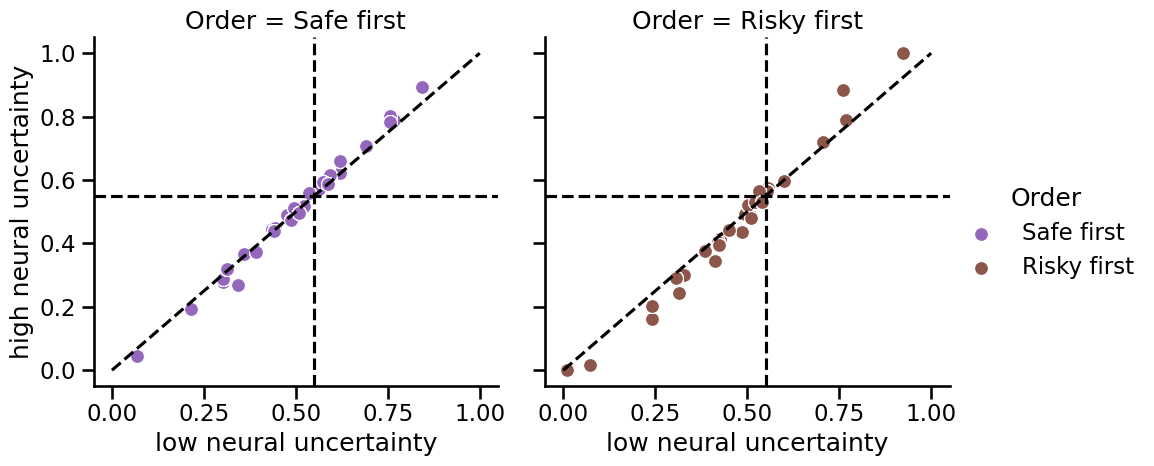

In [14]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)

mean_intercept, mean_gamma = intercept.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('intercept'), gamma.groupby(['subject', 'n_safe', 'risky_first', 'median_split_sd']).mean().mean(1).to_frame('gamma')
mean_rnp = np.clip(np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp'), 0, 1)

tmp = mean_rnp.unstack('median_split_sd')['rnp']
tmp.columns = ['low neural uncertainty', 'high neural uncertainty']
tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.FacetGrid(tmp.reset_index(), col='Order', height=5., hue='Order', palette=sns.color_palette()[4:])
fac.map(sns.scatterplot, 'low neural uncertainty', 'high neural uncertainty', s=100)

fac.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 1], c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axvline(0.55, c='k', ls='--'))

fac.add_legend()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6911, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_28332/1704015999.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color=sns.color_palette()[5])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_28332/1704015999.py:8: UserWarning: 



Text(0.5, 1.0, 'High neural uncertainty ~ Low neural uncertainty')

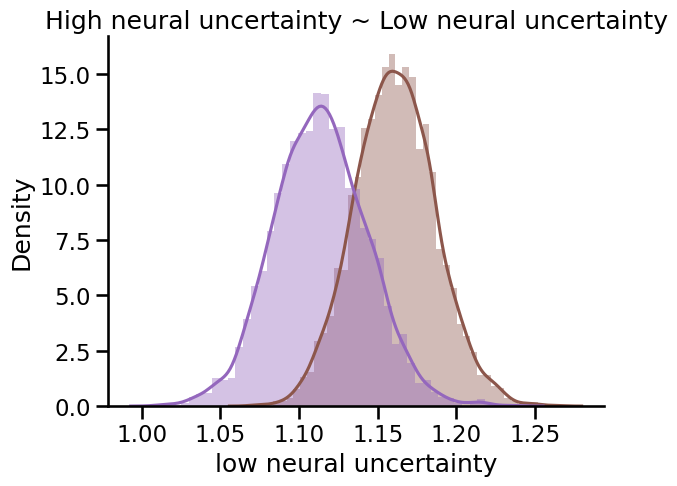

In [18]:
import bambi 

model = bambi.Model('"high neural uncertainty" ~ "low neural uncertainty"*Order + (1|subject)', data=tmp.groupby(['subject', 'Order']).mean().reset_index())

idata_lm = model.fit()

sns.distplot(idata_lm.posterior['low neural uncertainty'], label='Safe first', color=sns.color_palette()[5])
sns.distplot(idata_lm.posterior['low neural uncertainty'] + idata_lm.posterior['low neural uncertainty:Order'], label='Risky first',
             color=sns.color_palette()[4])
sns.despine()
plt.title('High neural uncertainty ~ Low neural uncertainty')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


0.431
0.16925


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25069/3938844776.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pars[pars.names == False].xs(True, 0, 'risky_first')['coef'])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_25069/3938844776.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bb

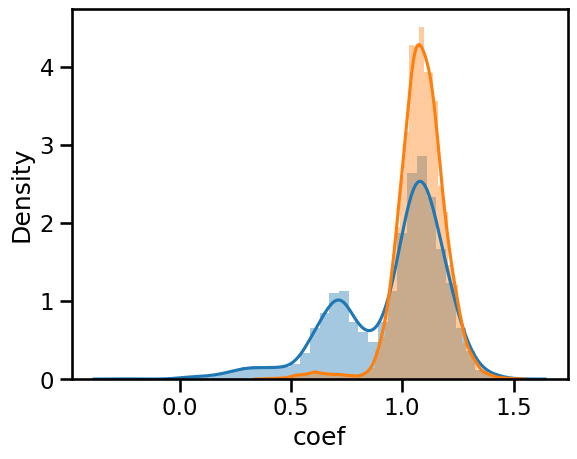

In [14]:
import pingouin
tmp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1).groupby(['subject', 'risky_first', 'median_split_sd']).mean().stack([0, 1]).to_frame('rnp')
pars = tmp.unstack('median_split_sd')['rnp'].groupby(['chain', 'risky_first', 'draw']).apply(lambda d: pingouin.linear_regression(d[False], d[True], add_intercept=True))
sns.distplot(pars[pars.names == False].xs(True, 0, 'risky_first')['coef'])
print((pars[pars.names == False].xs(True, 0, 'risky_first')['coef'] < 1.0).mean())
sns.distplot(pars[pars.names == False].xs(False, 0, 'risky_first')['coef'])
print((pars[pars.names == False].xs(False, 0, 'risky_first')['coef'] < 1.0).mean())

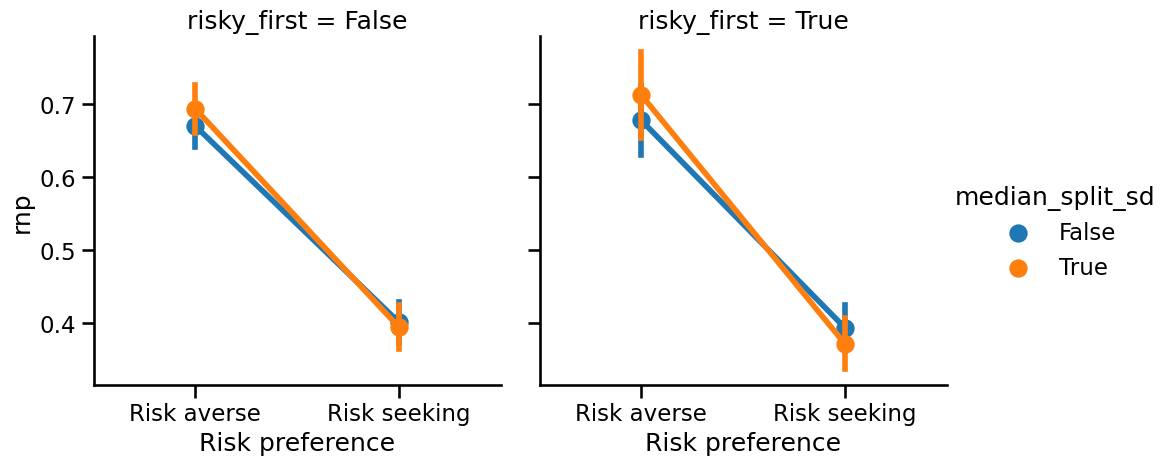

In [15]:
subjectwise_mean_rnp = mean_rnp.groupby(['subject', 'risky_first']).mean()
subject_type = (subjectwise_mean_rnp['rnp'] < .55).map({False:'Risk averse', True:'Risk seeking'})
subject_type.name = 'Risk preference'

tmp = mean_rnp.groupby(['subject', 'risky_first', 'median_split_sd']).mean().join(subject_type)

sns.catplot(tmp.reset_index(), x='Risk preference', y='rnp', col='risky_first', hue='median_split_sd', kind='point', errorbar='se')

In [16]:
import pingouin

In [17]:
pingouin.mixed_anova(tmp.xs(True, 0, 'risky_first').groupby(['subject', 'median_split_sd', 'Risk preference']).mean().reset_index(), dv='rnp', within='median_split_sd', between='Risk preference', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

Source        SS  DF1  DF2        MS          F     p-unc  \
0  Risk preference  1.142593    1   28  1.142593  24.228422  0.000034   
1  median_split_sd  0.000709    1   28  0.000709   1.242958  0.274380   
2      Interaction  0.009428    1   28  0.009428  16.521501  0.000353   

        np2  eps  
0  0.463893  NaN  
1  0.042505  1.0  
2  0.371090  NaN

In [18]:
pingouin.mixed_anova(tmp.xs(False, 0, 'risky_first').groupby(['subject', 'median_split_sd', 'Risk preference']).mean().reset_index(), dv='rnp', within='median_split_sd', between='Risk preference', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

Source        SS  DF1  DF2        MS          F         p-unc  \
0  Risk preference  1.120691    1   28  1.120691  39.633349  8.294196e-07   
1  median_split_sd  0.000288    1   28  0.000288   1.462194  2.366932e-01   
2      Interaction  0.003195    1   28  0.003195  16.207829  3.920065e-04   

        np2  eps  
0  0.586003  NaN  
1  0.049629  1.0  
2  0.366628  NaN

# Model 10

In [111]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [112]:
model_label = 'probit_neural10'
session = '3t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 19.51it/s]


['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd', 'risk_preference']


risky_first
False    0.114125
True     0.260750
dtype: float64

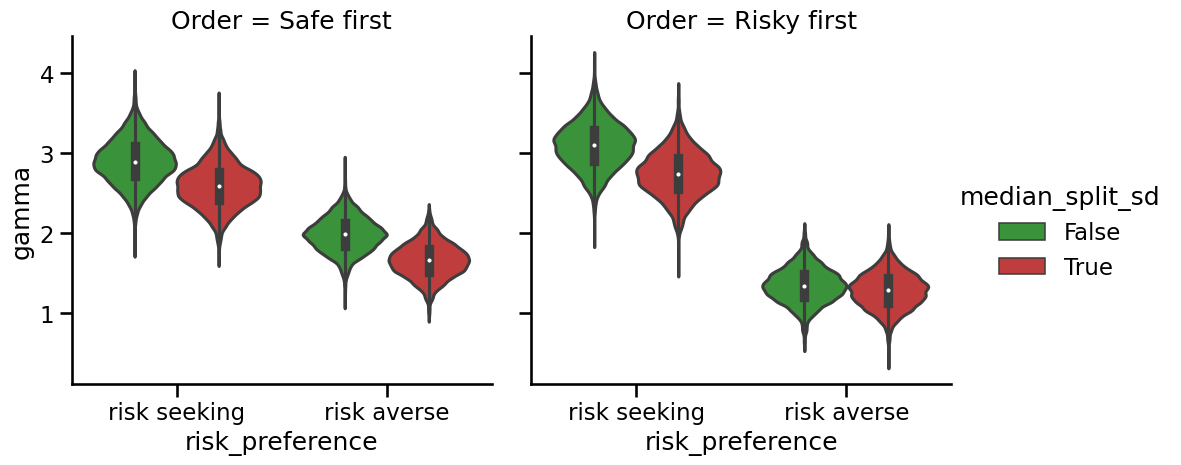

In [113]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.catplot(tmp.reset_index(), x='risk_preference', y='gamma', hue='median_split_sd', col='Order', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
# fac.set(xlabel='', xticks=[])
# fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

In [123]:
tmp = rnp.stack([0,1]).to_frame('rnp')
tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

tmp['Neural noise'] = tmp['median_split_sd'].map({True:'More noisy', False:'Less noisy'})

fac = sns.catplot(tmp.reset_index(), x='risk_preference', hue='median_split_sd', y='rnp', col='Order', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')

# fac.set(xlabel='', xticks=[])
fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))
# fac.set_titles('')
tmp.groupby(['risky_first']).apply(lambda d: ((d[('rnp', True)] - d[('rnp', False)]) > 0.0).mean())

KeyError: 'median_split_sd'

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_66736/2057015564.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seeking_diff)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_66736/2057015564.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(averse_diff)
/var/folders/

rnp    0.05725
dtype: float64

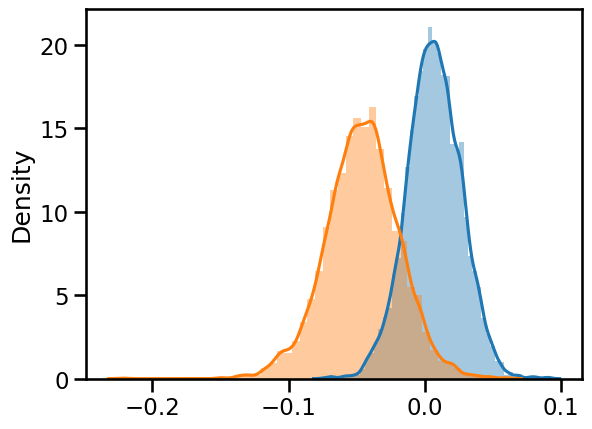

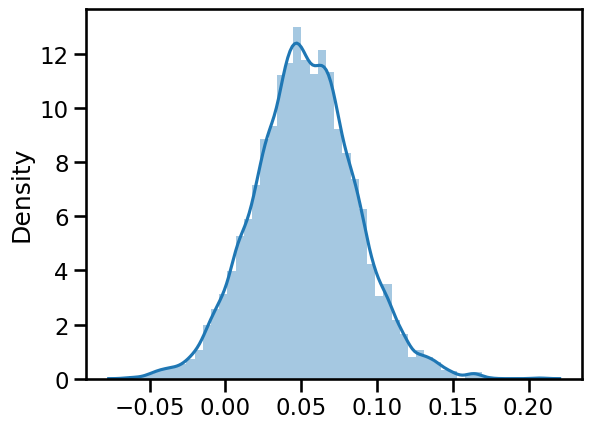

In [116]:
tmp = rnp.stack([0, 1]).to_frame('rnp')
seeking_diff = tmp.xs(True, 0, 'risky_first').xs('risk seeking', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs(True, 0, 'risky_first').xs('risk seeking', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 
averse_diff = tmp.xs(True, 0, 'risky_first').xs('risk averse', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs(True, 0, 'risky_first').xs('risk averse', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 

sns.distplot(seeking_diff)
sns.distplot(averse_diff)


plt.figure()
sns.distplot(seeking_diff - averse_diff)
1- ((seeking_diff - averse_diff) > 0.0).mean()

In [117]:
model_label = 'probit_neural10'
session = '7t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 29.30it/s]


['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd', 'risk_preference']


risky_first
False    0.694375
True     0.818625
dtype: float64

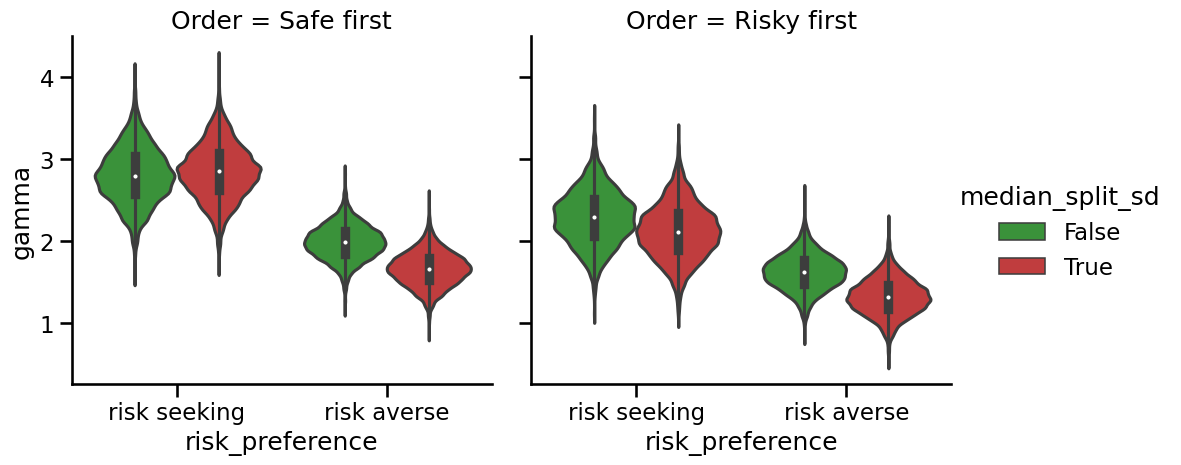

In [118]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

tmp['Order'] = tmp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})

fac = sns.catplot(tmp.reset_index(), x='risk_preference', y='gamma', hue='median_split_sd', col='Order', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
# fac.set(xlabel='', xticks=[])
# fac.set_titles('')
1 - tmp.groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

risky_first
False    0.485375
True     0.597750
dtype: float64

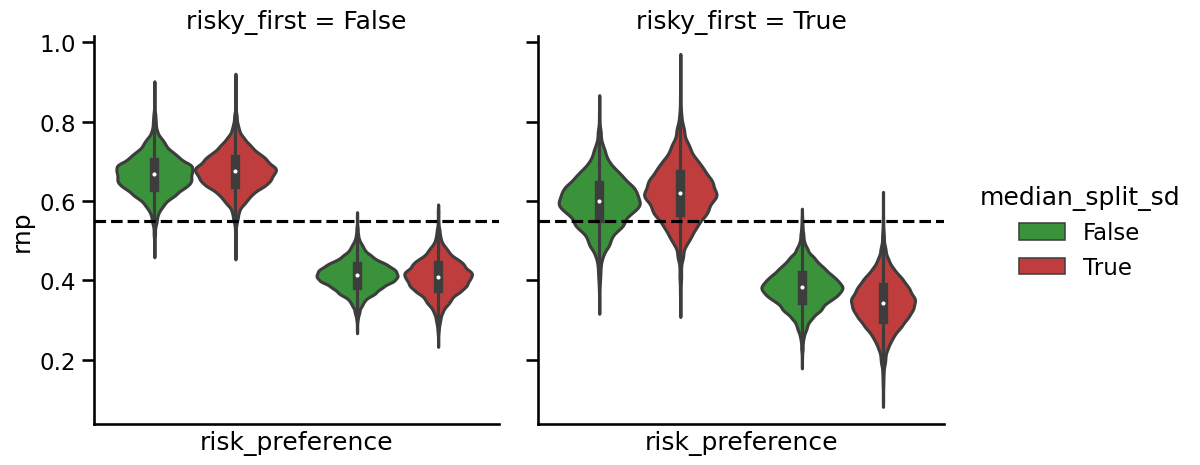

In [122]:
tmp = rnp.stack([0,1]).to_frame('rnp')

fac = sns.catplot(tmp.reset_index(), x='risk_preference', hue='median_split_sd', y='rnp', col='risky_first', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
fac.set(xticks=[])
fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))
# fac.set_titles('')
1 - tmp.groupby(['risky_first']).apply(lambda d: ((d[('rnp', True)] - d[('rnp', False)]) > 0.0).mean())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_66736/4226441224.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seeking_diff)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_66736/4226441224.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(averse_diff)
/var/folders/

rnp    0.062
dtype: float64

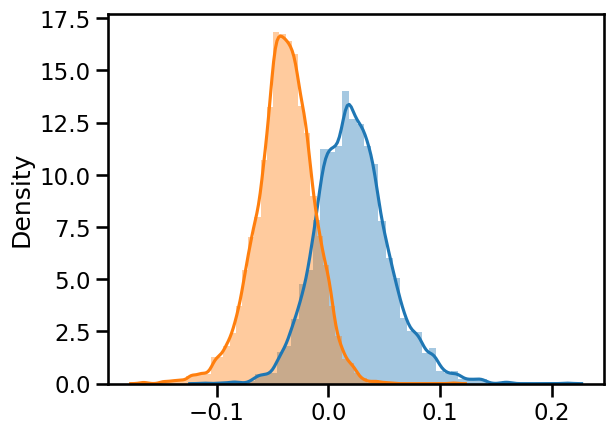

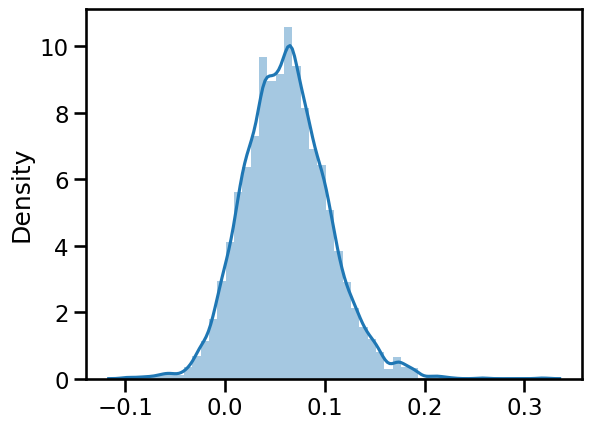

In [121]:
tmp = rnp.stack([0, 1]).to_frame('rnp')
seeking_diff = tmp.xs(True, 0, 'risky_first').xs('risk seeking', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs(True, 0, 'risky_first').xs('risk seeking', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 
averse_diff = tmp.xs(True, 0, 'risky_first').xs('risk averse', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs(True, 0, 'risky_first').xs('risk averse', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 

sns.distplot(seeking_diff)
sns.distplot(averse_diff)


plt.figure()
sns.distplot(seeking_diff - averse_diff)
((seeking_diff - averse_diff) < 0.0).mean()

# Model 107

In [51]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
model_label = 'probit_neural107'
session = '3t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)

idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 27.95it/s]


['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd', 'risk_preference']


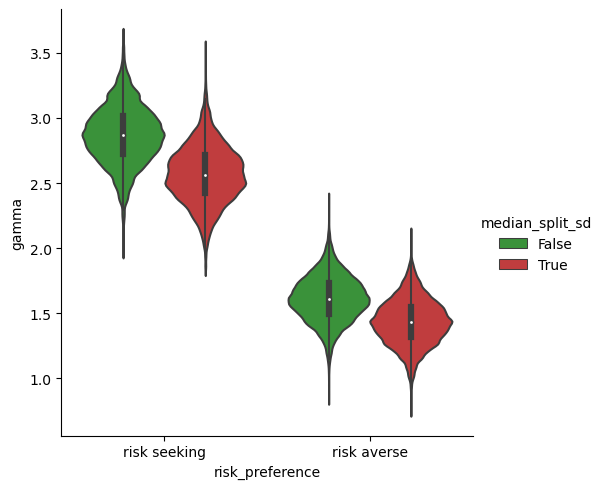

In [53]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

fac = sns.catplot(tmp.reset_index(), x='risk_preference', y='gamma', hue='median_split_sd', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
# fac.set(xlabel='', xticks=[])
# fac.set_titles('')
# .groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

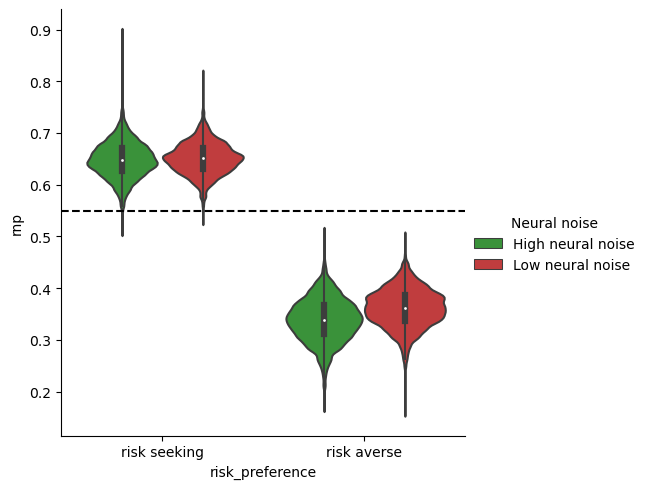

In [54]:
tmp = rnp.stack([0,1]).to_frame('rnp')

tmp = tmp.reset_index()

tmp['Neural noise'] = tmp['median_split_sd'].map({True:'High neural noise', False:'Low neural noise'})

fac = sns.catplot(tmp, x='risk_preference', y='rnp', hue='Neural noise', kind='violin', palette=sns.color_palette()[2:])
plt.axhline(0.55, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33458/1733915229.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seeking_diff)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33458/1733915229.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(averse_diff)
/var/folders/

rnp    0.169
dtype: float64

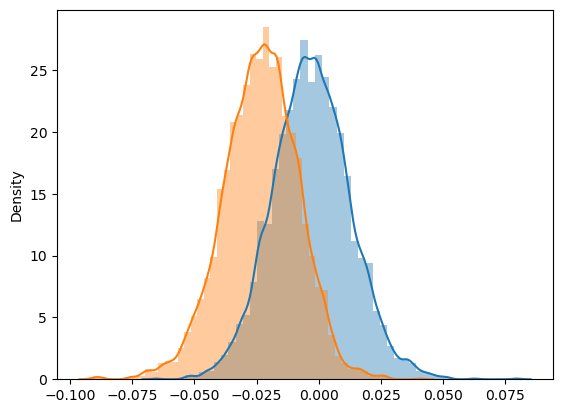

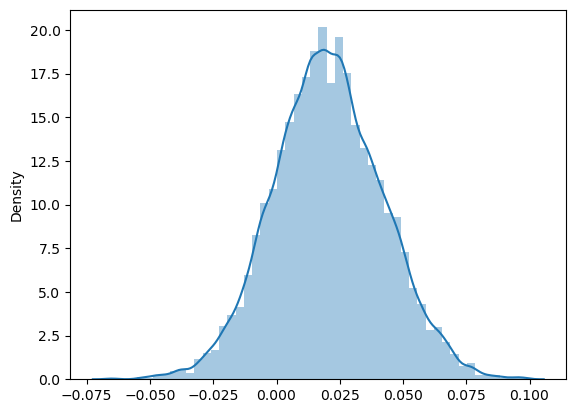

In [58]:
tmp = rnp.stack([0,1]).to_frame('rnp')
seeking_diff = tmp.xs('risk seeking', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs('risk seeking', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 
averse_diff = tmp.xs('risk averse', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs('risk averse', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 

sns.distplot(seeking_diff)
sns.distplot(averse_diff)


plt.figure()
sns.distplot(seeking_diff - averse_diff)
((seeking_diff - averse_diff) < 0.0).mean()

In [59]:
model_label = 'probit_neural107'
session = '7t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)

idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 27.63it/s]


['subject', 'x', 'n_safe', 'risky_first', 'sd', 'median_split_sd', 'risk_preference']


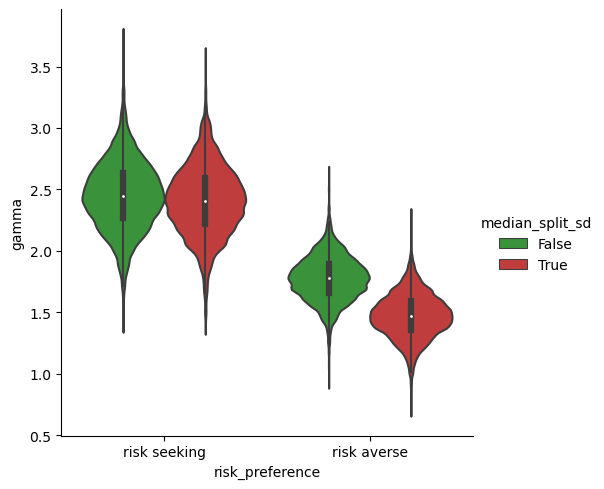

In [60]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)
tmp = gamma.stack([1,2])

fac = sns.catplot(tmp.reset_index(), x='risk_preference', y='gamma', hue='median_split_sd', kind='violin', palette=sns.color_palette()[2:])

tmp = tmp.unstack('median_split_sd')
# fac.set(xlabel='', xticks=[])
# fac.set_titles('')
# .groupby(['risky_first']).apply(lambda d: ((d[('gamma', True)] - d[('gamma', False)]) > 0.0).mean())

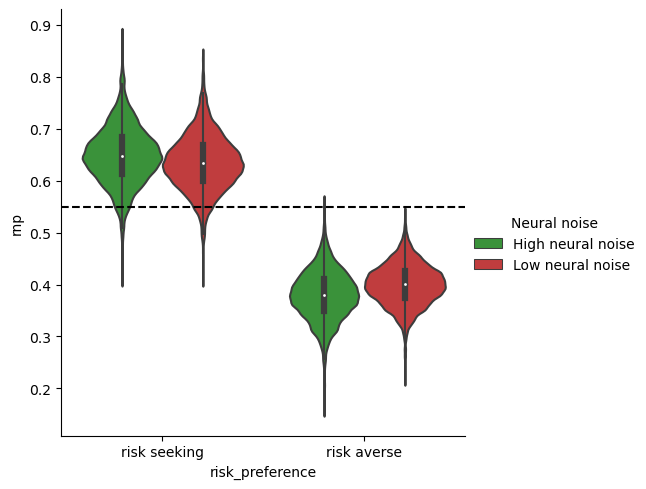

In [61]:
tmp = rnp.stack([0,1]).to_frame('rnp')

tmp = tmp.reset_index()

tmp['Neural noise'] = tmp['median_split_sd'].map({True:'High neural noise', False:'Low neural noise'})

fac = sns.catplot(tmp, x='risk_preference', y='rnp', hue='Neural noise', kind='violin', palette=sns.color_palette()[2:])
plt.axhline(0.55, c='k', ls='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33458/1733915229.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(seeking_diff)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33458/1733915229.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(averse_diff)
/var/folders/

rnp    0.09375
dtype: float64

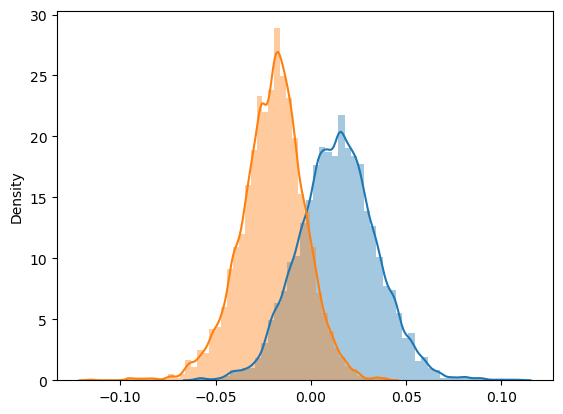

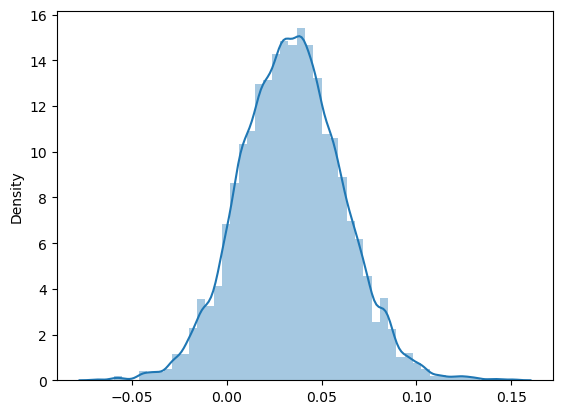

In [62]:
tmp = rnp.stack([0,1]).to_frame('rnp')
seeking_diff = tmp.xs('risk seeking', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs('risk seeking', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 
averse_diff = tmp.xs('risk averse', 0, 'risk_preference').xs(True, 0, 'median_split_sd') - tmp.xs('risk averse', 0, 'risk_preference').xs(False, 0, 'median_split_sd') 

sns.distplot(seeking_diff)
sns.distplot(averse_diff)


plt.figure()
sns.distplot(seeking_diff - averse_diff)
((seeking_diff - averse_diff) < 0.0).mean()

# Model 1072

In [17]:

import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
model_label = 'probit_neural1072'
session = '7t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)

idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')


100%|██████████| 30/30 [00:01<00:00, 20.41it/s]


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33458/2984250827.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['x:sd'].to_dataframe())


<Axes: ylabel='Density'>

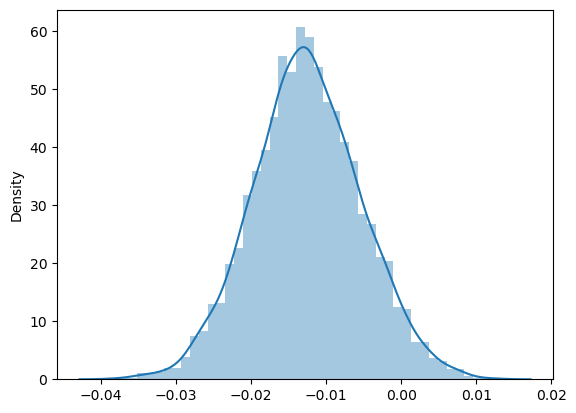

In [27]:
sns.distplot(idata.posterior['x:sd'].to_dataframe())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33458/3501046848.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['sd'].to_dataframe())


<Axes: ylabel='Density'>

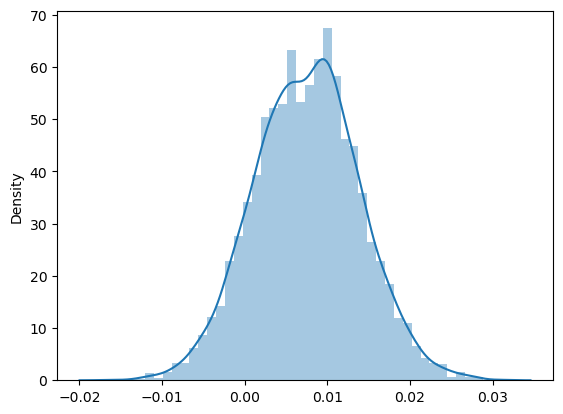

In [26]:
sns.distplot(idata.posterior['sd'].to_dataframe())

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_33458/1547431793.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['sd:risk_preference'].to_dataframe())


<Axes: ylabel='Density'>

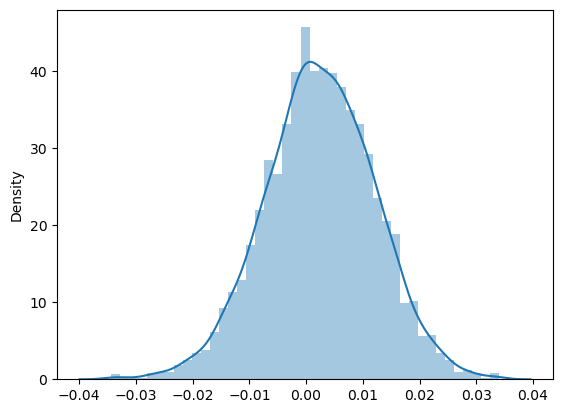

In [25]:
sns.distplot(idata.posterior['sd:risk_preference'].to_dataframe())

# pupil

In [1]:
import arviz as az
from fit_probit import build_model, get_data
from utils import get_fake_data, extract_intercept_gamma
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'fit_probit'

100%|██████████| 30/30 [00:00<00:00, 30.63it/s]


['subject', 'x', 'n_safe', 'risky_first', 'median_split_pupil_baseline']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


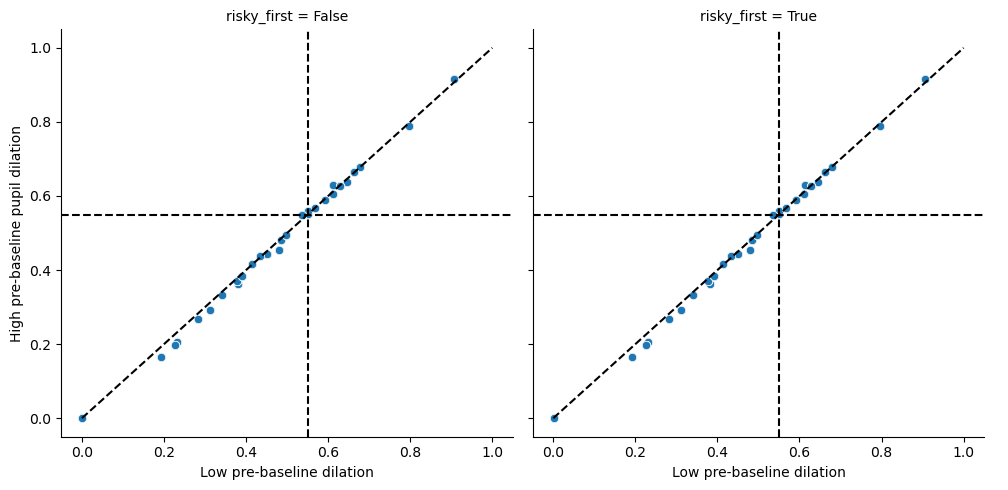

In [ ]:
model_label = 'probit_pupil1'
session = '3t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-probit_pupil1_ses-{session}_trace.netcdf')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)

mean_intercept, mean_gamma = intercept.groupby(['subject', 'n_safe', 'risky_first', 'median_split_pupil_baseline']).mean().mean(1).to_frame('intercept'), gamma.groupby(['subject', 'n_safe', 'risky_first', 'median_split_pupil_baseline']).mean().mean(1).to_frame('gamma')
mean_rnp = np.clip(np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp'), 0, 1)

tmp = mean_rnp.unstack('median_split_pupil_baseline')['rnp']
# tmp.columns = ['Low pupil baseline', 'High pupil baseline']

fac = sns.FacetGrid(tmp.reset_index(), col='risky_first', height=5.)
fac.map(sns.scatterplot, 'Low pre-baseline dilation', 'High pre-baseline pupil dilation')

fac.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 1], c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axvline(0.55, c='k', ls='--'))

fac.add_legend()

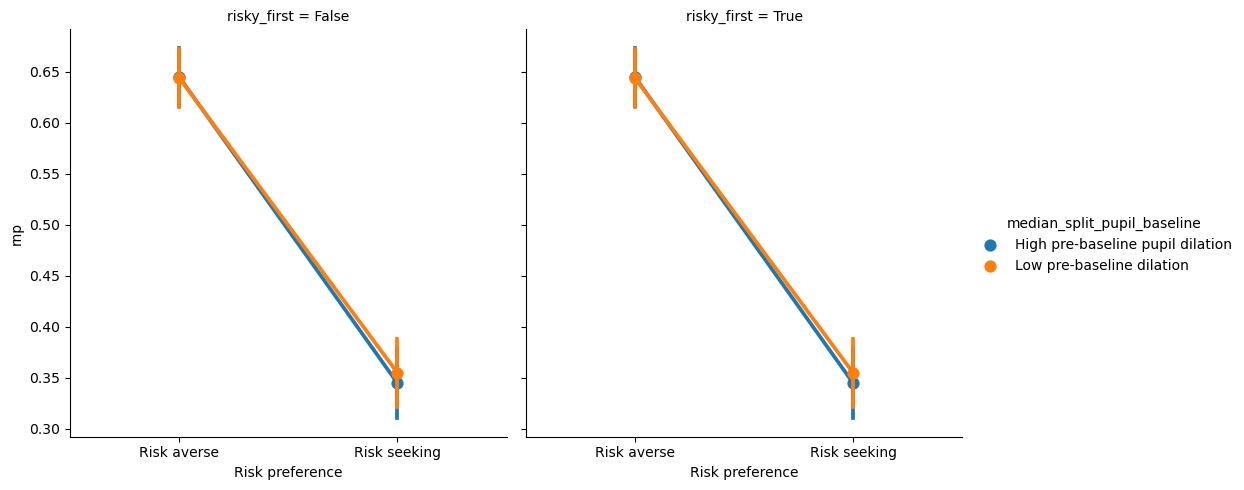

In [ ]:
subjectwise_mean_rnp = mean_rnp.groupby(['subject', 'risky_first']).mean()
subject_type = (subjectwise_mean_rnp['rnp'] < .55).map({False:'Risk averse', True:'Risk seeking'})
subject_type.name = 'Risk preference'

tmp = mean_rnp.groupby(['subject', 'risky_first', 'median_split_pupil_baseline']).mean().join(subject_type)

sns.catplot(tmp.reset_index(), x='Risk preference', y='rnp', col='risky_first', hue='median_split_pupil_baseline', kind='point', errorbar='se')

100%|██████████| 30/30 [00:01<00:00, 29.24it/s]


['subject', 'x', 'n_safe', 'risky_first', 'median_split_pupil_baseline']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


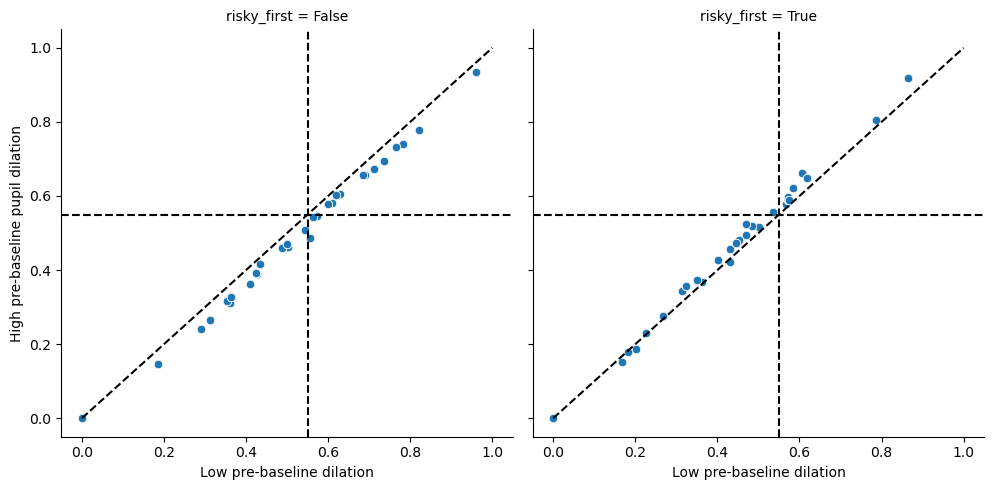

In [ ]:
model_label = 'probit_pupil2'
session = '3t2'
bids_folder = '/data/ds-risk'

df = get_data(model_label, session, bids_folder)
model = build_model(model_label, df, session, bids_folder)


idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-probit_pupil2_ses-{session}_trace.netcdf')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']), 0, 1)

mean_intercept, mean_gamma = intercept.groupby(['subject', 'n_safe', 'risky_first', 'median_split_pupil_baseline']).mean().mean(1).to_frame('intercept'), gamma.groupby(['subject', 'n_safe', 'risky_first', 'median_split_pupil_baseline']).mean().mean(1).to_frame('gamma')
mean_rnp = np.clip(np.exp(mean_intercept['intercept']/mean_gamma['gamma']).to_frame('rnp'), 0, 1)

tmp = mean_rnp.unstack('median_split_pupil_baseline')['rnp']
# tmp.columns = ['Low pupil baseline', 'High pupil baseline']

fac = sns.FacetGrid(tmp.reset_index(), col='risky_first', height=5.)
fac.map(sns.scatterplot, 'Low pre-baseline dilation', 'High pre-baseline pupil dilation')

fac.map(lambda *args, **kwargs: plt.plot([0, 1], [0, 1], c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
fac.map(lambda *args, **kwargs: plt.axvline(0.55, c='k', ls='--'))

fac.add_legend()

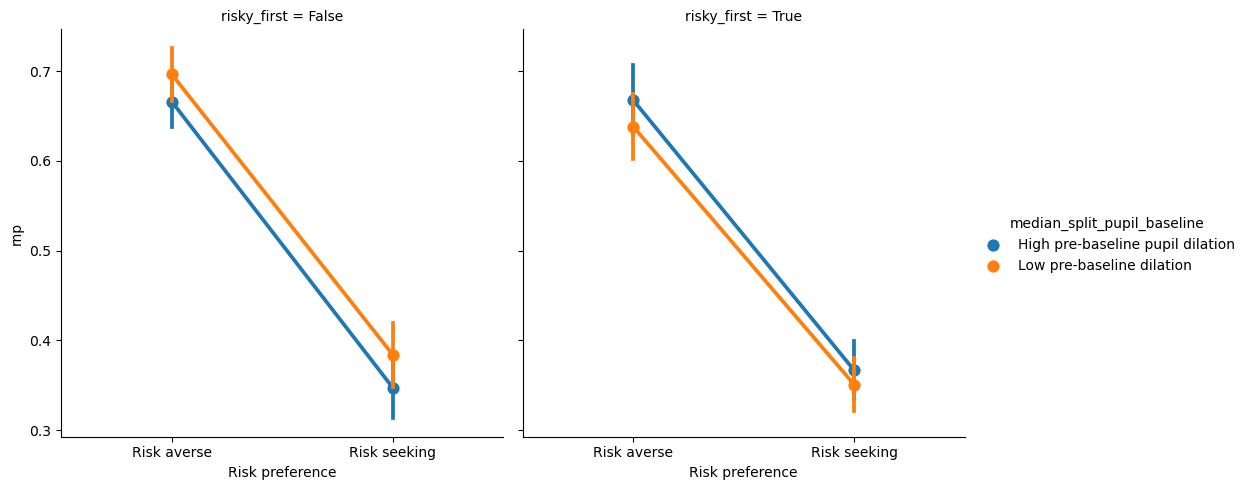

In [ ]:
subjectwise_mean_rnp = mean_rnp.groupby(['subject', 'risky_first']).mean()
subject_type = (subjectwise_mean_rnp['rnp'] < .55).map({False:'Risk averse', True:'Risk seeking'})
subject_type.name = 'Risk preference'

tmp = mean_rnp.groupby(['subject', 'risky_first', 'median_split_pupil_baseline']).mean().join(subject_type)

sns.catplot(tmp.reset_index(), x='Risk preference', y='rnp', col='risky_first', hue='median_split_pupil_baseline', kind='point', errorbar='se')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_81624/1646144048.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['risky_first:median_split_pupil_baseline'])


<xarray.DataArray 'risky_first:median_split_pupil_baseline' ()>
array(0.915)

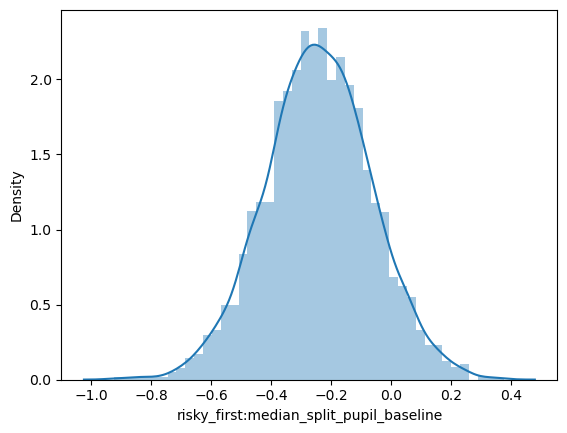

In [ ]:
sns.distplot(idata.posterior['risky_first:median_split_pupil_baseline'])

(idata.posterior['risky_first:median_split_pupil_baseline'] < 0.0).mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_81624/1754027242.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(idata.posterior['median_split_pupil_baseline'].to_dataframe())


<xarray.DataArray 'median_split_pupil_baseline' ()>
array(0.1775)

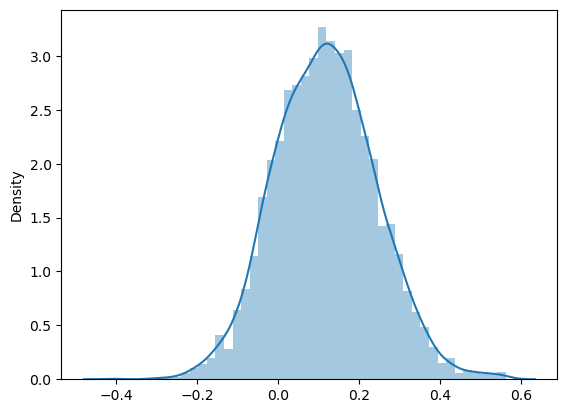

In [ ]:
sns.distplot(idata.posterior['median_split_pupil_baseline'].to_dataframe())

(idata.posterior['median_split_pupil_baseline'] < 0.0).mean()

In [7]:
import pingouin

In [12]:
pingouin.mixed_anova(tmp.xs(True, 0, 'risky_first').groupby(['subject', 'median_split_pupil_baseline', 'Risk preference']).mean().reset_index(), dv='rnp', within='median_split_pupil_baseline', between='Risk preference', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

Source        SS  DF1  DF2        MS          F  \
0              Risk preference  1.089567    1   28  1.089567  30.226182   
1  median_split_pupil_baseline  0.005995    1   28  0.005995  37.423093   
2                  Interaction  0.000578    1   28  0.000578   3.605965   

      p-unc       np2  eps  
0  0.000007  0.519117  NaN  
1  0.000001  0.572017  1.0  
2  0.067922  0.114091  NaN

In [13]:
pingouin.mixed_anova(tmp.xs(False, 0, 'risky_first').groupby(['subject', 'median_split_pupil_baseline', 'Risk preference']).mean().reset_index(), dv='rnp', within='median_split_pupil_baseline', between='Risk preference', subject='subject')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:551: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ss_resall = grp_with.apply(lambda x: (x - x.mean()) ** 2).sum()
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pingouin/parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

Source        SS  DF1  DF2        MS           F  \
0              Risk preference  1.485584    1   28  1.485584   47.099406   
1  median_split_pupil_baseline  0.017117    1   28  0.017117  221.416457   
2                  Interaction  0.000148    1   28  0.000148    1.910808   

          p-unc       np2  eps  
0  1.857181e-07  0.627161  NaN  
1  7.976083e-15  0.887738  1.0  
2  1.778016e-01  0.063884  NaN

In [53]:
idata = az.from_netcdf('/data/ds-risk/derivatives/cogmodels/model-probit_pupil3_ses-3t2_trace.netcdf')

In [54]:
idata.posterior

<xarray.Dataset>
Dimensions:                            (chain: 4, draw: 1000,
                                        subject__factor_dim: 30)
Coordinates:
  * chain                              (chain) int64 0 1 2 3
  * draw                               (draw) int64 0 1 2 3 ... 996 997 998 999
  * subject__factor_dim                (subject__factor_dim) object '02' ... ...
Data variables: (12/24)
    Intercept                          (chain, draw) float64 ...
    x                                  (chain, draw) float64 ...
    risky_first                        (chain, draw) float64 ...
    x:risky_first                      (chain, draw) float64 ...
    pupil                              (chain, draw) float64 ...
    x:pupil                            (chain, draw) float64 ...
    ...                                 ...
    risky_first|subject                (chain, draw, subject__factor_dim) float64 ...
    x:risky_first|subject              (chain, draw, subject__factor_dim) float64 ...
    pupil|subject                      (chain, draw, subject__factor_dim) float64 ...
    x:pupil|subject                    (chain, draw, subject__factor_dim) float64 ...
    risky_first:pupil|subject          (chain, draw, subject__factor_dim) float64 ...
    x:risky_first:pupil|subject        (chain, draw, subject__factor_dim) float64 ...
Attributes:
    created_at:                  2023-02-16T11:08:14.225100
    arviz_version:               0.14.0
    inference_library:           pymc
    inference_library_version:   4.2.0
    sampling_time:               181.97522807121277
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.9.1